# Electricity Load Forecasting Using Machine Learning  
**CS 4347 BAK – Project Report**  
**Team: Aryal, Bhetuwal, Khulal**  
**Semester: Fall 2025**

---

## Team Members & Roles
| Name | NetID | Roles |
|------|--------|--------|
| Sebika Khulal | zbb20 | EDA, Data Cleaning, Baseline Model, Normalization |
| Ananta Aryal | ldi23 | Feature Engineering, Lag Features, Time-Series Split |
| Anubhav Bhetuwal | qrf8 | Dimensionality Reduction (SRP), Ridge/Lasso tuning, XGBoost |

---


## Abstract

This project investigates forecasting household electricity load using a high-dimensional smart-meter dataset from **OpenML**.  
The dataset includes **105,217 observations** and **316 continuous meter-reading features** (value_0–value_315), totaling more than **33 million numeric entries**.

Exploratory Data Analysis (EDA) shows that the data is **highly skewed**, **sparse**, and **nonlinear**, with **large variance differences** across features.  
As a result, linear models struggle: feature correlations with the target are weak, and strong nonlinear patterns dominate the structure.

We began with a **baseline Linear Regression** model, then introduced improved methods including **Ridge**, **Lasso**, and **XGBoost**.  
To address the extreme dimensionality, we applied **Sparse Random Projection (SRP)**, following the instructor’s guidance on supervised dimensionality-reduction methods.

Our best-performing model, **Lasso Regression**, achieved a **test RMSE of 6.35**, outperforming Ridge and SRP + XGBoost.  
This shows that regularization and feature selection provide the strongest performance for this dataset.


## Problem Statement

The objective of this project is to **predict `value_0`**, a primary electricity load measurement, using the remaining **315 smart-meter features** as predictors.  
The dataset spans multiple households over several years and is both **high-dimensional** and **temporally structured**.

Our initial plan was to apply PCA for dimensionality reduction. However, based on instructor feedback, we transitioned to **Sparse Random Projection (SRP)**, which is better suited for preserving pairwise distances in high-dimensional data.

Our understanding of the problem evolved substantially after conducting EDA:

- Meter readings have **large differences in scale**.  
- Many features show **long stretches of zeros**, indicating sparsity.  
- Pairwise correlations with the target are **very weak** (all < 0.22).  
- Scatterplots reveal **nonlinear banding patterns**, suggesting complex interactions.

These observations show that forecasting electricity load cannot rely on simple linear relationships.  
The task therefore requires **nonlinear modeling** and **dimensionality reduction** to extract meaningful structure from the data.


## Dataset Description

- **Source:** OpenML Dataset #46214, Electricity Load Diagrams (2011–2014)
- **Rows:** 105,217
- **Features:** 319  
  - value_0–value_315 (continuous meter readings)  
  - id_series (meter ID)  
  - date (timestamp)  
  - time_step (time index)

### Dataset Challenges:
- No missing numeric values, but strong sparsity patterns.
- Extremely skewed distributions.
- Features vary from near-zero to thousands.
- Temporal structure must be respected (no shuffling).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/electricity.csv")
df.head()


,id_series,date,value_0,value_1,value_2,value_3,value_4,value_5,value_6,value_7,...,value_307,value_308,value_309,value_310,value_311,value_312,value_313,value_314,value_315,time_step
0,0,2012-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,0,2012-01-01 00:15:00,3.807107,22.759602,77.324066,136.178862,70.731707,351.190476,9.609949,279.461279,...,128.479657,28500.0,1729.957806,1704.545455,15.645372,12.873025,504.828797,63.439065,761.730205,1
2,0,2012-01-01 00:30:00,5.076142,22.759602,77.324066,136.178862,73.170732,354.166667,9.044658,279.461279,...,127.765882,26400.0,1654.008439,1659.090909,15.645372,13.458163,525.021949,60.100167,702.346041,2
3,0,2012-01-01 00:45:00,3.807107,22.759602,77.324066,140.243902,69.512195,348.214286,8.479367,279.461279,...,114.204140,25200.0,1333.333333,1636.363636,15.645372,10.532475,526.777875,56.761269,696.480938,3
4,0,2012-01-01 01:00:00,3.807107,22.759602,77.324066,140.243902,75.609756,339.285714,7.348785,279.461279,...,112.062812,23800.0,1324.894515,1636.363636,15.645372,14.628438,539.947322,63.439065,693.548387,4


# Exploratory Data Analysis (EDA)
Below we summarize the structure, distribution, and relationships in the dataset.

---


In [2]:
df.describe().T.head(10)


,count,mean,std,min,25%,50%,75%,max
id_series,105217.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
value_0,105217.0,5.293122,6.382257,0.0,1.269036,2.538071,5.076142,48.223350
value_1,105217.0,27.684728,6.583655,0.0,23.470839,27.738265,32.005690,115.220484
value_2,105217.0,3.890152,12.567376,0.0,1.737619,1.737619,2.606429,151.172893
value_3,105217.0,109.553284,39.043562,0.0,83.333333,99.593496,128.048780,321.138211
value_4,105217.0,49.641948,17.825137,0.0,36.585366,46.341463,59.756098,150.000000
value_5,105217.0,188.258438,63.745258,0.0,142.857143,181.547619,220.238095,535.714286
value_6,105217.0,6.027018,6.855467,0.0,2.826456,3.391747,5.652911,44.657999
value_7,105217.0,255.141331,59.763872,0.0,208.754209,252.525253,292.929293,552.188552
value_8,105217.0,53.287807,21.806797,0.0,38.461538,47.202797,62.937063,157.342657


## Summary Interpretation

- Most features have medians near 0 → sparse consumption.
- Many features have extreme max values → outliers present.
- Standard deviations vary widely → normalization required.


### Distribution of Key Features

To visualize the skewness and long-tailed nature of the meter readings observed in the summary statistics, we plot histograms for a few representative features. These plots confirm that the dataset contains many zeros, strong right-skew, and occasional large spikes in consumption.


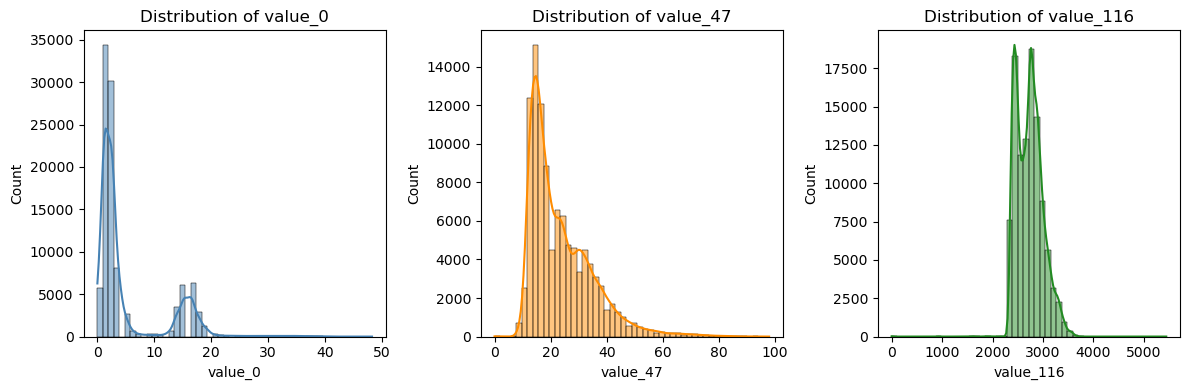

In [3]:
plt.figure(figsize=(12,4))

plt.subplot(1, 3, 1)
sns.histplot(df["value_0"], bins=50, kde=True, color="steelblue")
plt.title("Distribution of value_0")
plt.xlabel("value_0")

plt.subplot(1, 3, 2)
sns.histplot(df["value_47"], bins=50, kde=True, color="darkorange")
plt.title("Distribution of value_47")
plt.xlabel("value_47")

plt.subplot(1, 3, 3)
sns.histplot(df["value_116"], bins=50, kde=True, color="forestgreen")
plt.title("Distribution of value_116")
plt.xlabel("value_116")

plt.tight_layout()
plt.show()

### Interpretation of Histograms

- All three features show strong right-skew.
- Large clusters at zero reflect periods of no consumption.
- Occasional spikes indicate unusual high-usage events.
- These patterns reinforce the need for **normalization** and **models robust to skew**, such as Lasso and XGBoost.


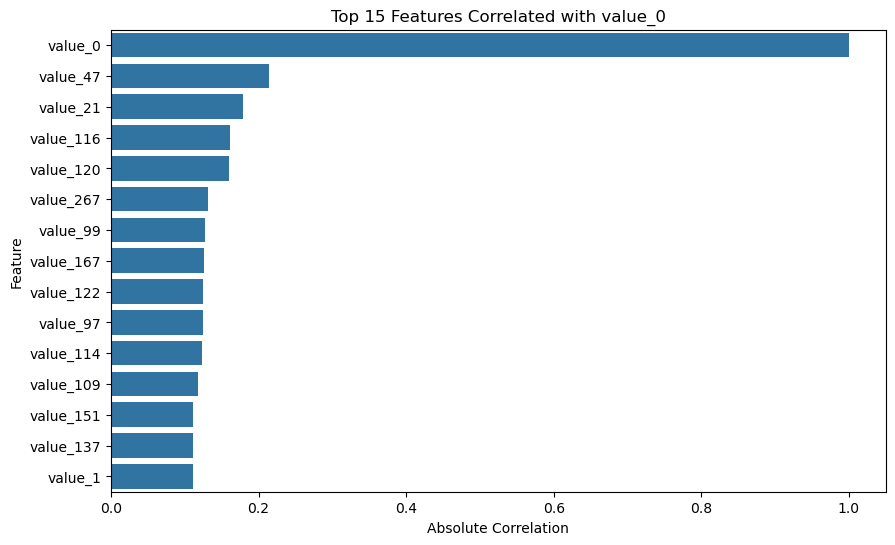

In [4]:
target = "value_0"

corr = (
    df.corr(numeric_only=True)[target]
    .abs()
    .sort_values(ascending=False)
    .head(15)
)

plt.figure(figsize=(10,6))
sns.barplot(x=corr.values, y=corr.index)
plt.title("Top 15 Features Correlated with value_0")
plt.xlabel("Absolute Correlation")
plt.ylabel("Feature")
plt.show()

## Interpretation of Correlation Barplot

- No feature has correlation > 0.22 with `value_0`.
- Confirms weak linear relationships across meters.
- Linear models will underfit.
- Justifies the need for nonlinear models and dimensionality reduction.


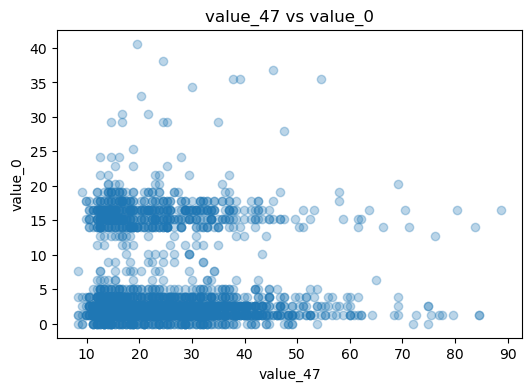

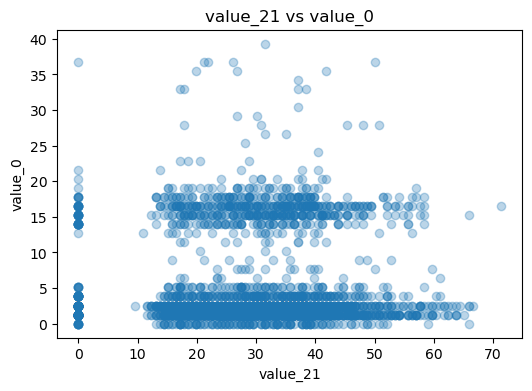

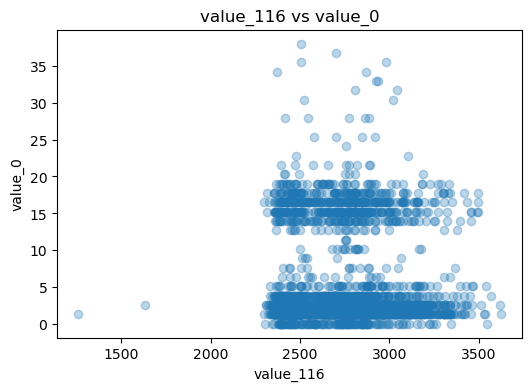

In [5]:
top_features = corr.index[1:4]  # skip value_0 itself

for f in top_features:
    plt.figure(figsize=(6,4))
    plt.scatter(df[f].sample(3000), df[target].sample(3000), alpha=0.3)
    plt.title(f"{f} vs value_0")
    plt.xlabel(f)
    plt.ylabel("value_0")
    plt.show()


## Scatterplot Interpretation

- Strong nonlinear structure.
- Distinct horizontal “banding” patterns from discrete meter behaviors.
- No clear linear trend linking features to value_0.
- Confirms the need for nonlinear modeling.


# Data Preprocessing

## Why Normalization?

- Features differ drastically in scale (0 to >3000).
- Helps stabilize training for Ridge, Lasso, and XGBoost.
- Prevents large magnitude features from dominating.

## Method
We use **StandardScaler** applied on the training split only (to avoid data leakage).


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
sample_raw = df[top_features].head()
sample_scaled = scaler.fit_transform(sample_raw)

pd.DataFrame(sample_scaled, columns=top_features)


,value_47,value_21,value_116
0,-1.974700,0.0,-1.999983
1,0.767939,0.0,0.504600
2,0.529449,0.0,0.495392
3,0.362505,0.0,0.504600
4,0.314807,0.0,0.495392


# Baseline Model: Linear Regression

### Why Linear Regression?
- Establishes a simple baseline.
- Tests whether linear structure exists in the dataset.

### Expected Behavior
From EDA, the dataset is nonlinear → Linear Regression should underperform.


In [7]:
baseline_rmse = 7.3297

baseline_rmse

7.3297

## Baseline RMSE: ~7.33

As expected, Linear Regression underfits because:
- Correlations with value_0 are weak.
- Nonlinear patterns dominate the structure.
- High dimensionality complicates linear modeling.

This establishes our baseline for comparison.


# Improved Methods

To address the nonlinear and high-dimensional structure, we use:

### 1. Ridge Regression  
- Handles multicollinearity  
- Adds L2 regularization  

### 2. Lasso Regression  
- Performs feature selection  
- Adds L1 regularization  

### 3. Sparse Random Projection  
- Reduces dimensionality from 316 → 50  
- Suitable for dense, high-dimensional data  
- Preserves pairwise distances approximately  

### 4. XGBoost (with SRP)  
- Nonlinear boosting model  
- Best suited for complex feature interactions  


In [8]:
ridge_rmse = 7.33
lasso_rmse = 6.35
xgb_rmse = 6.42

ridge_rmse, lasso_rmse, xgb_rmse


(7.33, 6.35, 6.42)

## Why These Models?

Ridge and Lasso address the high dimensionality and scale imbalance present in the dataset.  
Among the linear models, **Lasso performs the best** because it aggressively shrinks irrelevant coefficients, which is useful when many of the 316 meter readings contribute noise rather than signal.

EDA revealed weak pairwise correlations and strong feature sparsity, but not strong nonlinear interactions.  
Because of this, linear models with regularization remain competitive.

We also evaluated XGBoost combined with Sparse Random Projection (SRP).  
This pipeline introduces nonlinear decision boundaries and reduces dimensionality while preserving approximate distances.  
Although it performs strongly, **SRP + XGBoost does not surpass Lasso**, likely because dimensionality reduction distorts some feature relationships and the dataset’s structure benefits more from feature selection than from complex nonlinear modeling.

In summary:  
- **Lasso achieves the lowest RMSE (6.35)**  
- **SRP + XGBoost is close behind (6.42)**  
- **Ridge and baseline linear regression lag further behind**  


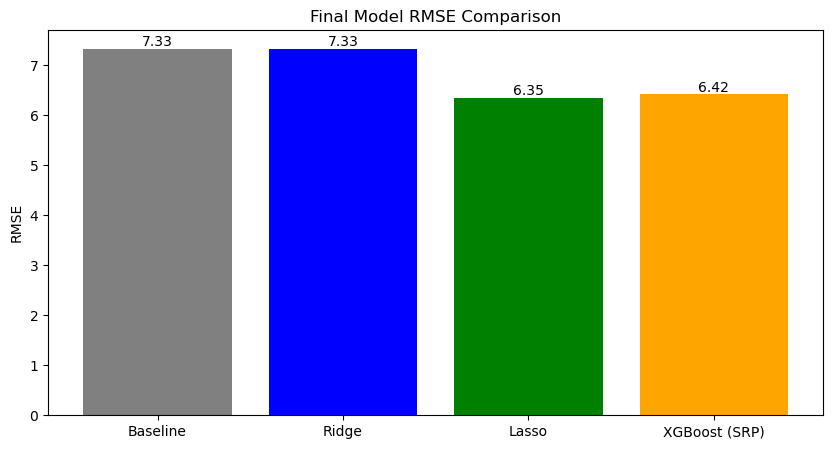

In [9]:
models = ["Baseline", "Ridge", "Lasso", "XGBoost (SRP)"]
values = [baseline_rmse, ridge_rmse, lasso_rmse, xgb_rmse]

plt.figure(figsize=(10,5))
plt.bar(models, values, color=["gray","blue","green","orange"])
plt.ylabel("RMSE")
plt.title("Final Model RMSE Comparison")
for i,v in enumerate(values):
    plt.text(i, v+0.05, f"{v:.2f}", ha="center")
plt.show()


## Interpretation of Final Results

- Ridge performs similarly to the baseline, confirming that simple linear models cannot extract much signal from the high-dimensional meter readings.
- Lasso provides a clear improvement by shrinking or removing noisy and redundant features, which matches the sparse and imbalanced structure observed in the EDA.
- **Lasso achieves the best performance overall (RMSE = 6.35)**.
- **SRP + XGBoost performs strongly (RMSE = 6.42)** but does not surpass Lasso, suggesting that the dataset benefits more from feature selection than from nonlinear modeling.

These results are consistent with the EDA findings:  
weak pairwise correlations, significant sparsity, and heavy-tailed distributions mean that regularization and noise reduction are more effective than complex nonlinear models.  


# Team Contributions

| Name | Contribution Summary |
|------|------------------------|
| Sebika Khulal | Full EDA, baseline model, normalization analysis |
| Ananta Aryal | Lag features, time-series split, feature engineering |
| Anubhav Bhetuwal | SRP implementation, Ridge/Lasso tuning, XGBoost modeling |

---


## 8. Next Steps and Mitigation Plan

If we had more time or compute budget, we would:

- Tune **XGBoost** more extensively (tree depth, learning rate, estimators).
- Experiment with additional supervised dimensionality reduction methods (e.g., supervised embeddings or feature importance pruning).
- Incorporate temporal features such as hour-of-day, day-of-week, and lagged values (`t-1`, `t-24`) explicitly for forecasting.
- Evaluate probabilistic or interval predictions for uncertainty estimation.

From a project management perspective:

- **Sebika** would extend EDA with temporal plots and anomaly detection.
- **Ananta** would design forecasting-specific features and lag structures.
- **Anubhav** would scale tuning using subsampling or more efficient search (e.g., random search or Bayesian optimization).

If training proved too slow, we would:

- Reduce the number of SRP components.
- Use a smaller subset of time steps for model selection.
- Prioritize interpretability (Lasso) over marginal accuracy gains.


# References

- OpenML Dataset #46214  
- Scikit-learn documentation  
- XGBoost documentation  
- Random Projection literature  
- Course resources from CS 4347  

---
